In [20]:
import numpy as np
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

In [21]:
DATAROOT = 'D:/ThesisProjects/nuScenes_dataset/'

nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

In [22]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

train = get_prediction_challenge_split("train", dataroot=DATAROOT)
valid = get_prediction_challenge_split("train_val", dataroot=DATAROOT)
test = get_prediction_challenge_split("val", dataroot=DATAROOT)

In [23]:
from nuscenes.prediction.models.physics import ConstantAccelerationHeading, ConstantVelocityHeading
from nuscenes.prediction.models.physics import ConstantAccelerationYaw, ConstantSpeedYaw, PhysicsOracle

prediction_length = 6

cah_model = ConstantAccelerationHeading(sec_from_now=prediction_length, helper=helper)
cv_model = ConstantVelocityHeading(sec_from_now=prediction_length, helper=helper)
ca_model = ConstantAccelerationYaw(sec_from_now=prediction_length, helper=helper)
csy_model = ConstantSpeedYaw(sec_from_now=prediction_length, helper=helper)

physics_oracle = PhysicsOracle(sec_from_now=prediction_length, helper=helper)

#### Visualization as BEV

In [24]:
# Reimport all needed libraries
import importlib
import custom_prediction.custom_input_representation.interface
import custom_prediction.custom_input_representation.agents
import custom_prediction.helper
import custom_prediction.custom_input_representation.static_layers
import nuscenes.prediction.models.physics 

importlib.reload(custom_prediction.custom_input_representation.interface)
importlib.reload(custom_prediction.custom_input_representation.agents)
importlib.reload(custom_prediction.helper)
importlib.reload(custom_prediction.custom_input_representation.static_layers)
importlib.reload(nuscenes.prediction.models.physics)

<module 'nuscenes.prediction.models.physics' from 'C:\\Projects\\anaconda3\\lib\\site-packages\\nuscenes\\prediction\\models\\physics.py'>

In [25]:
from custom_prediction.custom_input_representation.static_layers import StaticLayerRasterizer
from custom_prediction.custom_input_representation.agents import AgentBoxesWithFadedHistory, AgentBoxesWithFutureTrajectory
from custom_prediction.custom_input_representation.interface import InputRepresentation
from custom_prediction.custom_input_representation.combinators import Rasterizer

from typing import Dict

# Bird-eye for input representation
input_static_layer_rasterizer = StaticLayerRasterizer(helper)
input_agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)

input_representation = InputRepresentation(input_static_layer_rasterizer, input_agent_rasterizer, Rasterizer())

# Bird-eye visualization
static_colors = [[255, 255, 255], [136, 136, 136], [64, 64, 64]]

static_layer_rasterizer = StaticLayerRasterizer(helper, colorful_lines=False, colors=static_colors) #, meters_ahead=60, meters_left=30, meters_right=30, meters_behind=50, lanes_in_radius=80)
agent_rasterizer = AgentBoxesWithFutureTrajectory(helper, seconds_of_history=0) # meters_ahead=60, meters_left=30, meters_right=30, meters_behind=50)

vizualization_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

In [26]:
def generate_input_representation(instance_token, sample_token):
    img = input_representation.make_input_representation(instance_token, sample_token)
    return img

def generate_scene_visualization(instance_token, sample_token, trajectory_predictions:Dict[str, np.ndarray]):
    img = vizualization_representation.make_input_representation(instance_token, sample_token, trajectory_predictions)

    return img

In [27]:
from IPython.display import Image
import imageio

def save_gif(img_list, file_name='./test_bev/example.gif'):
    imageio.mimsave(f'{file_name}', img_list, duration=0.5)

In [28]:
indx = 660
instance_token, sample_token = train[indx].split("_")

In [29]:
center_agent_annotation = helper.get_sample_annotation(instance_token, sample_token)

agent_start_translation = center_agent_annotation['translation']
agent_start_rotation = center_agent_annotation['rotation']

agent_start_translation, agent_start_rotation

([1175.509, 1138.026, 0.951],
 [0.31043586992993333, 0.0, 0.0, 0.9505943249677254])

In [30]:
# cv_model(f"{instance_token}_{sample_token}")

In [31]:
pred = physics_oracle(f"{instance_token}_{sample_token}")
pred

Prediction(instance=1c41842170074ce4923ea02fe1fbbe45, sample=0d10ce0bb9ff43ee8e86142596564c94, prediction=[[[1173.2661526  1139.6657735 ]
  [1171.02330521 1141.305547  ]
  [1168.78045781 1142.94532049]
  [1166.53761042 1144.58509399]
  [1164.29476302 1146.22486749]
  [1162.05191563 1147.86464099]
  [1159.80906823 1149.50441449]
  [1157.56622084 1151.14418798]
  [1155.32337344 1152.78396148]
  [1153.08052605 1154.42373498]
  [1150.83767865 1156.06350848]
  [1148.59483126 1157.70328198]]], probabilities=[1])

In [32]:
coords = pred.prediction[0]
coords

array([[1173.2661526 , 1139.6657735 ],
       [1171.02330521, 1141.305547  ],
       [1168.78045781, 1142.94532049],
       [1166.53761042, 1144.58509399],
       [1164.29476302, 1146.22486749],
       [1162.05191563, 1147.86464099],
       [1159.80906823, 1149.50441449],
       [1157.56622084, 1151.14418798],
       [1155.32337344, 1152.78396148],
       [1153.08052605, 1154.42373498],
       [1150.83767865, 1156.06350848],
       [1148.59483126, 1157.70328198]])

In [33]:
from custom_prediction.helper import convert_global_coords_to_local

coords = convert_global_coords_to_local(coords,
                                        agent_start_translation,
                                        agent_start_rotation)

trajectory_predictions = [coords]
trajectory_predictions

[array([[5.04041253e-14, 2.77834871e+00],
        [1.00808251e-13, 5.55669742e+00],
        [1.50990331e-13, 8.33504613e+00],
        [2.01616501e-13, 1.11133948e+01],
        [2.52242671e-13, 1.38917436e+01],
        [3.01980663e-13, 1.66700923e+01],
        [3.51718654e-13, 1.94484410e+01],
        [4.03233003e-13, 2.22267897e+01],
        [4.54747351e-13, 2.50051384e+01],
        [5.04485342e-13, 2.77834871e+01],
        [5.54223334e-13, 3.05618358e+01],
        [6.03961325e-13, 3.33401845e+01]])]

In [34]:
trajectories_with_probability = list(zip(trajectory_predictions, [1]))

all_prediction_dict = {instance_token: trajectories_with_probability}
all_prediction_dict

{'1c41842170074ce4923ea02fe1fbbe45': [(array([[5.04041253e-14, 2.77834871e+00],
          [1.00808251e-13, 5.55669742e+00],
          [1.50990331e-13, 8.33504613e+00],
          [2.01616501e-13, 1.11133948e+01],
          [2.52242671e-13, 1.38917436e+01],
          [3.01980663e-13, 1.66700923e+01],
          [3.51718654e-13, 1.94484410e+01],
          [4.03233003e-13, 2.22267897e+01],
          [4.54747351e-13, 2.50051384e+01],
          [5.04485342e-13, 2.77834871e+01],
          [5.54223334e-13, 3.05618358e+01],
          [6.03961325e-13, 3.33401845e+01]]),
   1)]}

In [35]:
import matplotlib.pyplot as plt

def show_img(img, size=4):
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

Gen time: 0.439 sec; shape: (500, 500, 3)


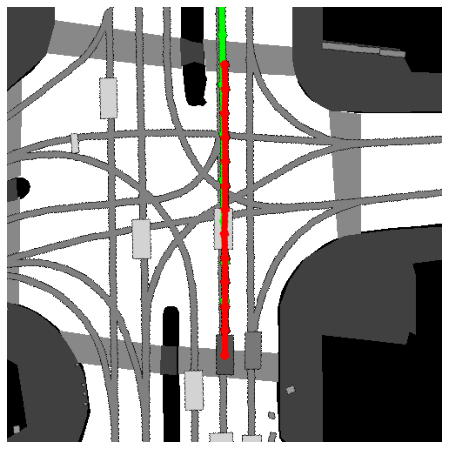

In [51]:
import time

start_time = time.time()

img = generate_scene_visualization(instance_token, sample_token, all_prediction_dict)
print(f'Gen time: {round(time.time() - start_time, 3)} sec; shape: {img.shape}')

show_img(img, 8)

In [36]:
def get_scene_representation_sequence(target_instance_token, start_prediction_sample_token, prediction_length,
                                      render_annotation=False, render_path_on_canvas=False, render_bev=True):

    current_sample_token = start_prediction_sample_token

    images_to_gif = []

    for i in range(prediction_length * 2):
        current_sample = nusc.get('sample', current_sample_token)
        
        center_agent_annotation = helper.get_sample_annotation(target_instance_token, current_sample_token)

        agent_start_translation = center_agent_annotation['translation']
        agent_start_rotation = center_agent_annotation['rotation']

        if render_annotation:
            # TODO: Get camera's views        
            nusc.render_annotation(annotation['token'])
        
        # Get prediction
        inference_start_time = time.time()
        world_coords = csy_model(f"{target_instance_token}_{current_sample_token}").prediction[0]
        local_coords = convert_global_coords_to_local(world_coords,
                                                      agent_start_translation,
                                                      agent_start_rotation)
        
        print(f'inf time: {round(time.time() - inference_start_time, 3)}')
                    
#         # Draw on canvas
#         if render_path_on_canvas:
#             gt = helper.get_future_for_agent(instance_token, current_sample_token, 6, in_agent_frame=True)
#             if len(gt) > 0:
#                 draw_prediction_on_canvas(gt, sorted_trajectories, mode_probabilities)
        
        # Draw on BEY
        trajectories_with_probability = list(zip([local_coords], [1]))
        all_prediction_dict = {instance_token: trajectories_with_probability}
        
        img = generate_scene_visualization(target_instance_token, current_sample_token, all_prediction_dict)
        
        if render_bev:
            show_img(img)

        images_to_gif.append(img)
        
        current_sample_token = current_sample['next']

        if current_sample_token == '':
            break

    file_name = f'./test_bev/{target_instance_token}_{start_prediction_sample_token}.gif'
    save_gif(images_to_gif, file_name)
    return file_name

inf time: 0.002


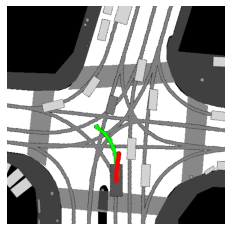

inf time: 0.001


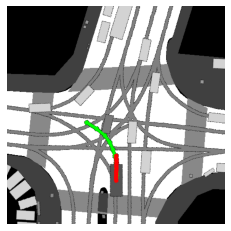

inf time: 0.001


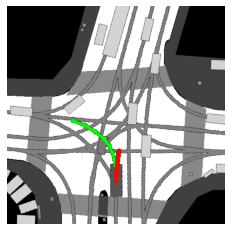

inf time: 0.001


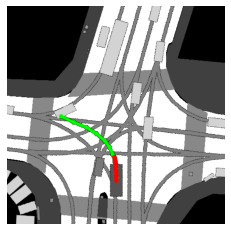

inf time: 0.001


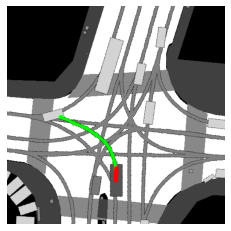

inf time: 0.001


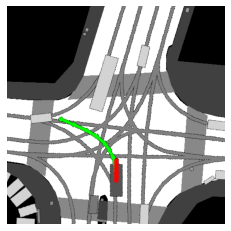

inf time: 0.001


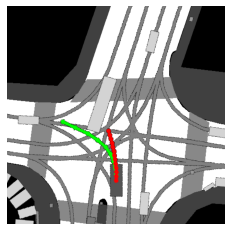

inf time: 0.001


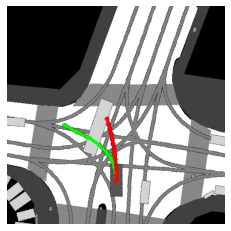

inf time: 0.001


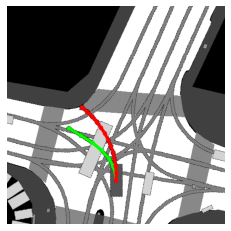

inf time: 0.001


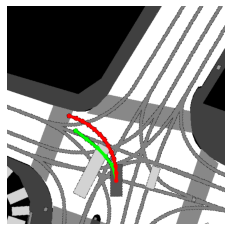

inf time: 0.001


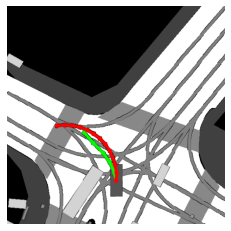

inf time: 0.002


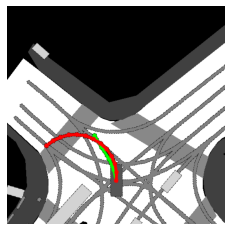

In [92]:
instance_token, sample_token = train[50].split("_")

file_name = get_scene_representation_sequence(instance_token, sample_token, prediction_length)

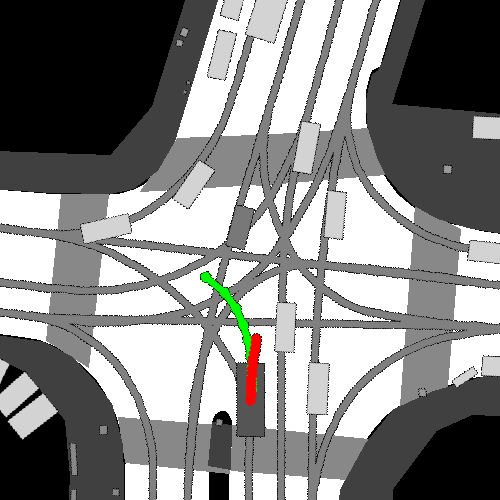

In [93]:
Image(filename=file_name, width = 300)

inf time: 0.001


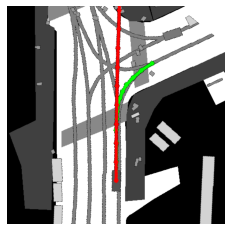

inf time: 0.001


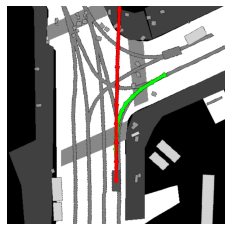

inf time: 0.001


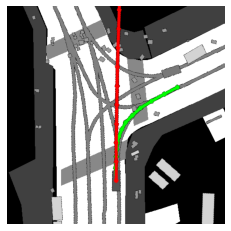

inf time: 0.001


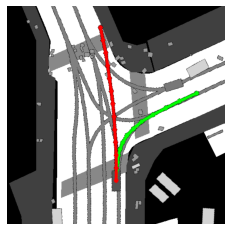

inf time: 0.001


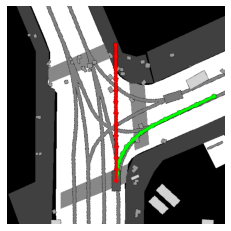

inf time: 0.001


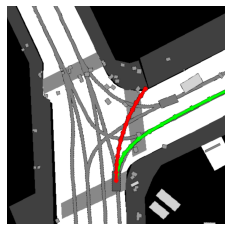

inf time: 0.001


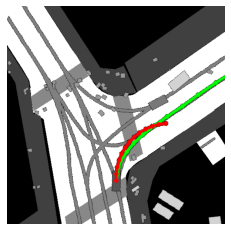

inf time: 0.001


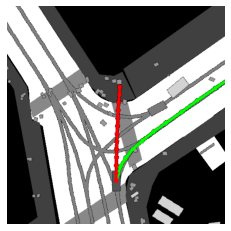

inf time: 0.002


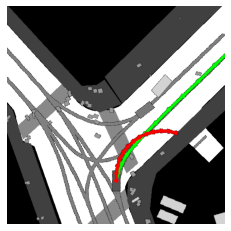

inf time: 0.001


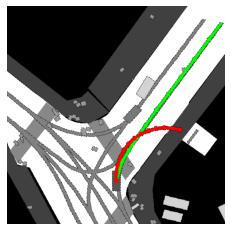

inf time: 0.001


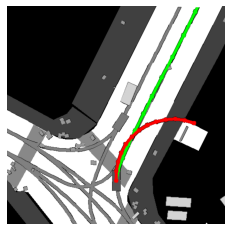

inf time: 0.002


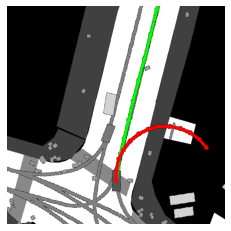

inf time: 0.001


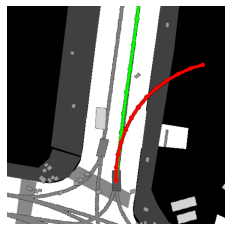

inf time: 0.001


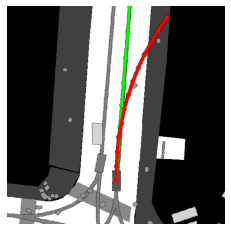

inf time: 0.001


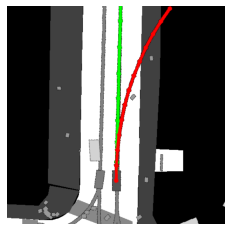

inf time: 0.001


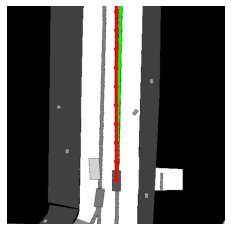

inf time: 0.001


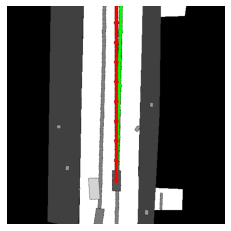

inf time: 0.001


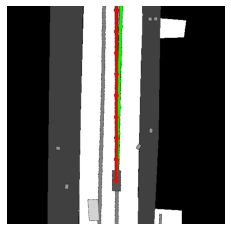

inf time: 0.001


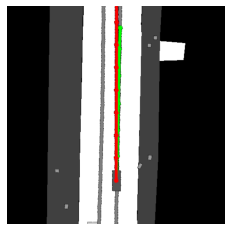

inf time: 0.002


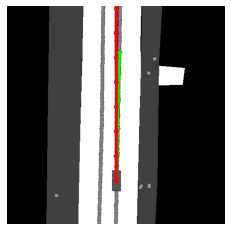

In [144]:
instance_token, sample_token = train[740].split("_")

file_name = get_scene_representation_sequence(instance_token, 'ef316fb422c24907bc01dd789c2c87b6', 10)

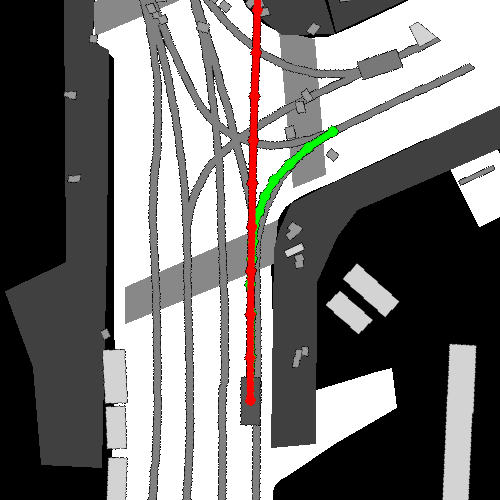

In [145]:
Image(filename=file_name, width = 300)

inf time: 0.001


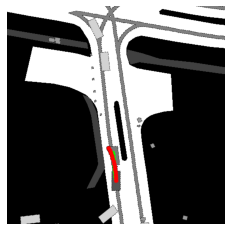

inf time: 0.001


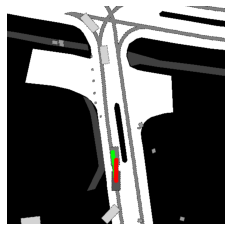

inf time: 0.001


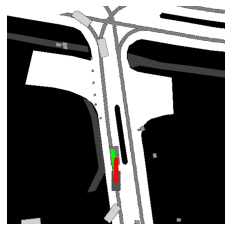

inf time: 0.001


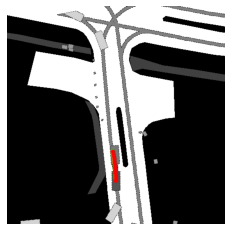

inf time: 0.001


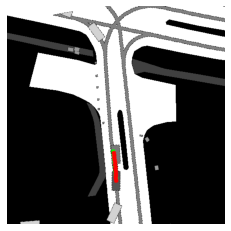

inf time: 0.001


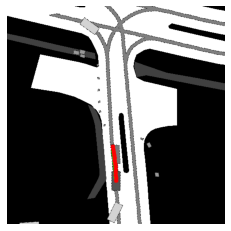

inf time: 0.002


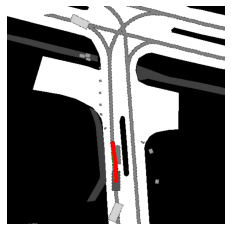

inf time: 0.002


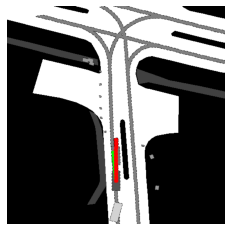

inf time: 0.001


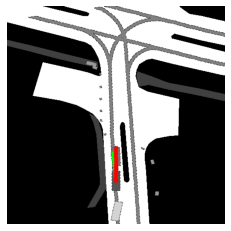

inf time: 0.001


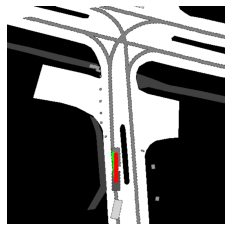

inf time: 0.001


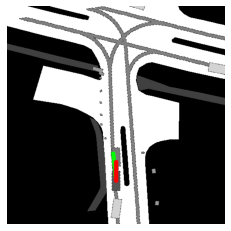

inf time: 0.001


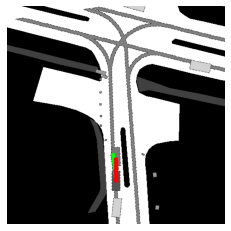

In [37]:
instance_token, sample_token = test[17].split("_")

file_name = get_scene_representation_sequence(instance_token, sample_token, prediction_length)

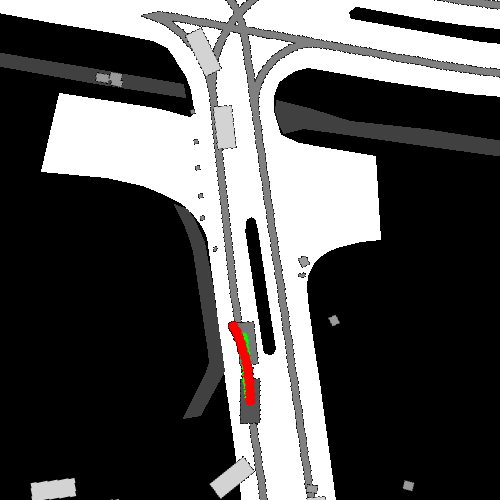

In [38]:
Image(filename=file_name, width = 300)

### Caclulate metrics

In [126]:
import nuscenes.eval.prediction.metrics as metrics
from collections import defaultdict
from typing import List, Dict, Any


def get_metrics_predictions(physics_model, instance_token, sample_token):

    prediction = physics_model(f"{instance_token}_{sample_token}")
    
    # Convert to agent frame
    center_agent_annotation = helper.get_sample_annotation(instance_token, sample_token)
    agent_start_translation = center_agent_annotation['translation']
    agent_start_rotation = center_agent_annotation['rotation']
    
    world_coords = prediction.prediction[0]
    local_coords = convert_global_coords_to_local(world_coords,
                                                  agent_start_translation,
                                                  agent_start_rotation)
    
    prediction.prediction = local_coords
        
    return prediction


def get_metrics(physics_model, valid_samples):
    
    # Define metrics function and container
    metric_functions = [metrics.MinFDEK([1], aggregators=[metrics.RowMean()]),
                        metrics.MinADEK([1], aggregators=[metrics.RowMean()]),
                        metrics.MissRateTopK([1], tolerance=2, aggregators=[metrics.RowMean()])]

    num_predictions = len(valid_samples) # Amount of prediction rows (equals of len of validation)
    metrics_container = {metric.name: np.zeros((num_predictions, metric.shape)) for metric in metric_functions}
    
    # Prediction loop
    for idx in range(len(valid_samples)):
        sample = valid_samples[idx]
        instance_tkn, sample_tkn = sample.split("_")
                        
        # Make prediction
        prediction = get_metrics_predictions(physics_model, instance_tkn, sample_tkn)
        
        # Get ground_truth
        ground_truth = helper.get_future_for_agent(instance_tkn, sample_tkn, 6, in_agent_frame=True)
        gt = ground_truth.reshape((12, 2))

        # Calculate metrics
        for metric in metric_functions:
            metrics_container[metric.name][idx] = metric(gt, prediction)
    
    # Metrics aggregations
    aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

    for metric in metric_functions:
        for agg in metric.aggregators:
            aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

    return aggregations

In [128]:
get_metrics(physics_oracle, valid)

defaultdict(dict,
            {'MinFDEK': {'RowMean': [8.990011288914712]},
             'MinADEK': {'RowMean': [3.6492656460034136]},
             'MissRateTopK_2': {'RowMean': [0.8880841121495328]}})

In [127]:
get_metrics(csy_model, valid)

defaultdict(dict,
            {'MinFDEK': {'RowMean': [11.059266647408059]},
             'MinADEK': {'RowMean': [4.446563120341319]},
             'MissRateTopK_2': {'RowMean': [0.9309579439252337]}})

In [129]:
get_metrics(ca_model, valid)

defaultdict(dict,
            {'MinFDEK': {'RowMean': [17.730494654264973]},
             'MinADEK': {'RowMean': [6.650092266945932]},
             'MissRateTopK_2': {'RowMean': [0.9480140186915887]}})

In [130]:
get_metrics(cv_model, valid)

defaultdict(dict,
            {'MinFDEK': {'RowMean': [11.4942384779106]},
             'MinADEK': {'RowMean': [4.737476494498296]},
             'MissRateTopK_2': {'RowMean': [0.9247663551401869]}})

In [138]:
get_metrics(cah_model, valid)

defaultdict(dict,
            {'MinFDEK': {'RowMean': [19.151137457903413]},
             'MinADEK': {'RowMean': [7.431641642564685]},
             'MissRateTopK_2': {'RowMean': [0.9452102803738318]}})